### <b> Problem Statement: </b>
Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.
Perform following tasks:
1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and random forest regression models.
5. Evaluate the models and compare their respective scores like R2, RMSE, etc.

### <b> Solution: </b>
### Step 1: Importing libraries and Dataset

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [25]:
data = pd.read_csv('Datasets/uber.csv')

In [26]:
data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


### Step 2: Data Preprocessing

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


Dropping unnecessary columns

In [28]:
data = data.drop(columns=['Unnamed: 0','key'])

Changing the float64 to float32

In [29]:
# data[data.select_dtypes(np.float64).columns] = data.select_dtypes(np.float64).astype(np.float32)
# data.info()

<Figure size 1440x1080 with 0 Axes>

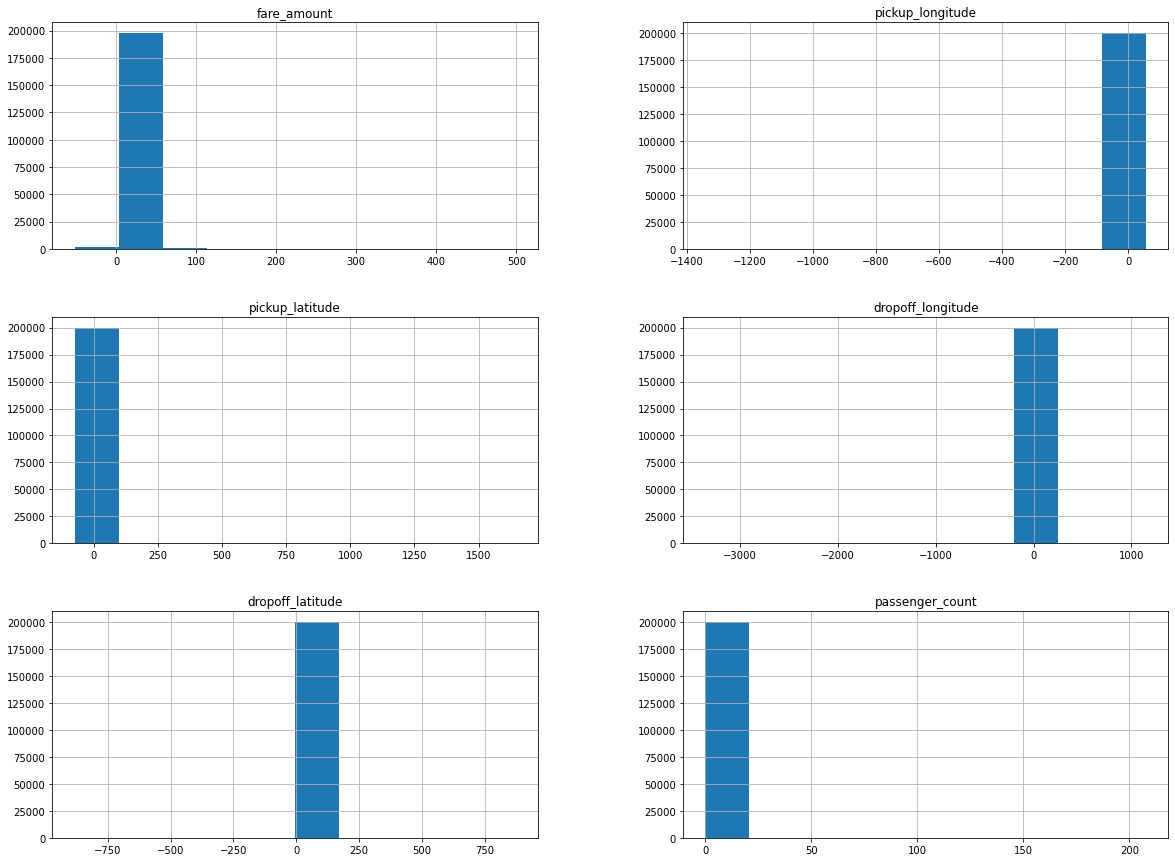

In [30]:
plt.figure(figsize=(20,15))
data.hist(figsize=(20,15))
plt.show()

#### Identifying outliers

<AxesSubplot:>

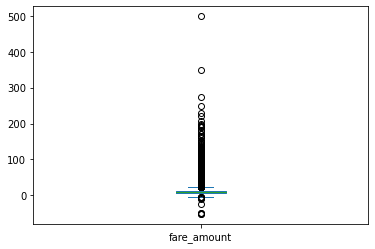

In [31]:
data.fare_amount.plot(kind='box')

In [32]:
fig = px.box(data, y='fare_amount')
fig.show()

In [33]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

data['Year'] = data['pickup_datetime'].apply(lambda time: time.year)
data['Month'] = data['pickup_datetime'].apply(lambda time: time.month)
data['Day'] = data['pickup_datetime'].apply(lambda time: time.day)
data['Day of Week'] = data['pickup_datetime'].apply(lambda time: time.dayofweek)
data['Day of Week_num'] = data['pickup_datetime'].apply(lambda time: time.dayofweek)
data['Hour'] = data['pickup_datetime'].apply(lambda time: time.hour)

day_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
data['Day of Week'] = data['Day of Week'].map(day_map)

data['counter'] = 1

In [34]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day,Day of Week,Day of Week_num,Hour,counter
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,Thu,3,19,1
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,Fri,4,20,1
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,Mon,0,21,1
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,Fri,4,8,1
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,Thu,3,17,1


In [35]:
data.dropna(axis = 0, inplace= True)

Dropping columns which we don't need in model building

In [36]:
data = data.drop(['pickup_datetime', 'Day of Week', 'counter'], axis=1)
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day,Day of Week_num,Hour
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,3,19
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,4,20
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,0,21
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,4,8
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,3,17


### Correlation

<AxesSubplot:>

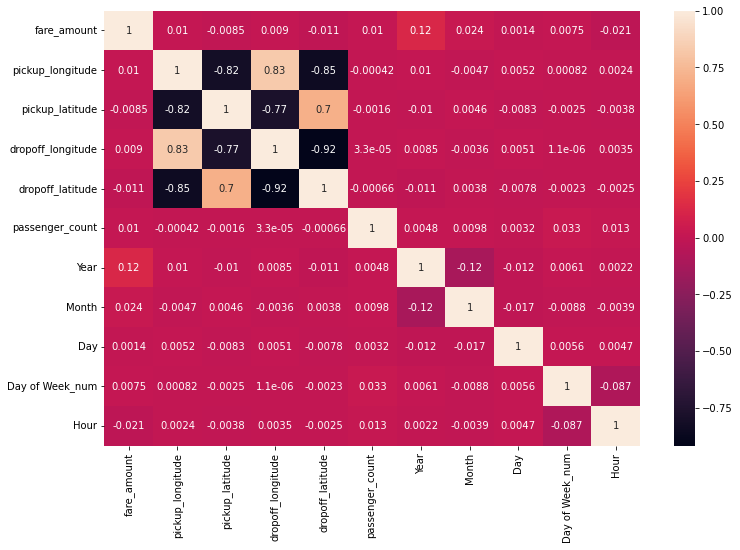

In [37]:
plt.subplots(figsize=(12,8))
sns.heatmap(data.corr(), annot=True)

#### Model Building

#### Splitting the dataset

Input Data = Rest  of the columns (Independent Variables)<br>
Output Data = Fare (Dependent Variables)

In [38]:
# Input Data
x = data.drop(['fare_amount'], axis=1)

# Output Data
y = data['fare_amount']

In [39]:
print(x)
print(y)

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.999817        40.738354         -73.999512   
1             -73.994355        40.728225         -73.994710   
2             -74.005043        40.740770         -73.962565   
3             -73.976124        40.790844         -73.965316   
4             -73.925023        40.744085         -73.973082   
...                  ...              ...                ...   
199995        -73.987042        40.739367         -73.986525   
199996        -73.984722        40.736837         -74.006672   
199997        -73.986017        40.756487         -73.858957   
199998        -73.997124        40.725452         -73.983215   
199999        -73.984395        40.720077         -73.985508   

        dropoff_latitude  passenger_count  Year  Month  Day  Day of Week_num  \
0              40.723217                1  2015      5    7                3   
1              40.750325                1  2009      7   17            

#### <b>Splitting the dataset into Train and Test

In [40]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=5)

print("xtrain shape: ", x_train.shape)
print("xtest shape: ", x_test.shape)
print("ytrain shape: ", y_train.shape)
print("ytest shape: ", y_test.shape)

xtrain shape:  (149999, 10)
xtest shape:  (50000, 10)
ytrain shape:  (149999,)
ytest shape:  (50000,)


### <b> Step 5: Training the model

In [41]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model = model.fit(x_train, y_train)

### <b> Step 6: Predicting the test results

In [42]:
y_pred = model.predict(x_test)
y_pred

array([13.14161312, 10.61059051, 10.52464951, ...,  9.69992823,
       12.40068246, 12.63013735])

### <b> Step 7: Evaluating the model

In [43]:
from sklearn.metrics import mean_squared_error, r2_score

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Square Error : ", mse)

# Root Mean Squared Error
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
print("Root Mean Square Error : ", rmse)

# R2 score 
r2 = r2_score(y_test, y_pred)
print("R^2 score: ", r2)

Mean Square Error :  92.83074404857919
Root Mean Square Error :  9.634871252309456
R^2 score:  0.015591938317488951


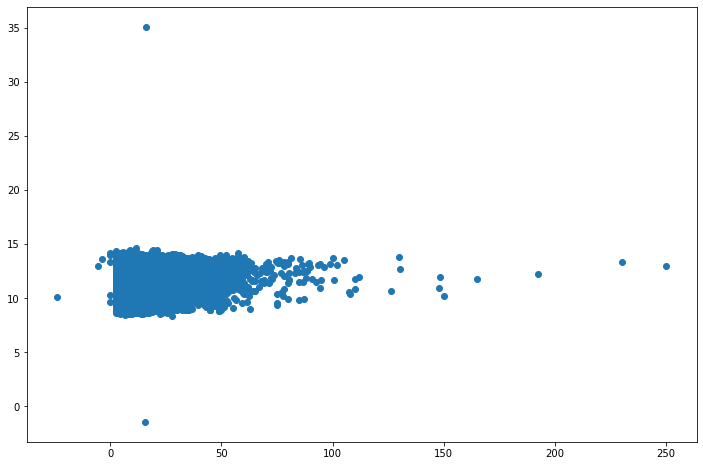

In [44]:
plt.subplots(figsize=(12,8))
plt.scatter(y_test, y_pred)
# plt.xlabel("Actual Prices")
# plt.ylabel("Predicted prices")
# plt.title("Actual Prices vs Predicted prices")
plt.show()

Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor

rfrmodel = RandomForestRegressor(n_estimators=100, random_state=101)

rfrmodel.fit(x_train, y_train)

RandomForestRegressor(random_state=101)

In [46]:
ypred = rfrmodel.predict(xtest)
ypred

NameError: name 'xtest' is not defined

In [ ]:
rfrmodel_rmse=np.sqrt(mean_squared_error(ypred, ytest))
print("RMSE value for Random forest regression is ",rfrmodel_rmse)

RMSE value for Random forest regression is  4.590135340794553


In [ ]:
r2 = r2_score(ytest, ypred)
print("R^2 score: ", r2)

R^2 score:  0.7765736904129894


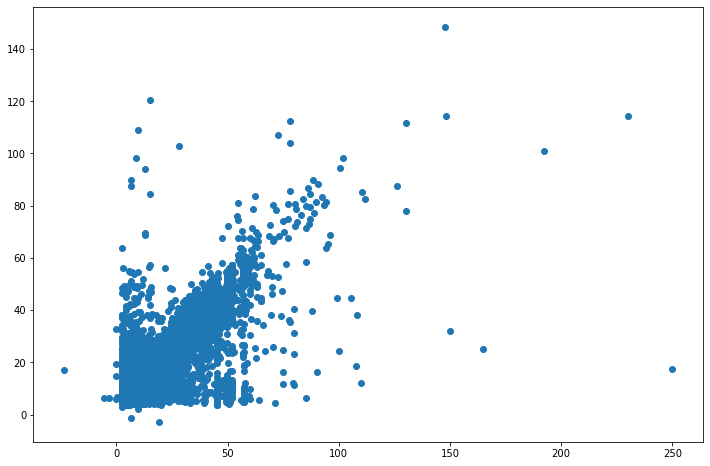

In [ ]:
plt.subplots(figsize=(12,8))
plt.scatter(ytest, ypred)
# plt.xlabel("Actual Prices")
# plt.ylabel("Predicted prices")
# plt.title("Actual Prices vs Predicted prices")
plt.show()